In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from redist import modifier
from redist import plot
from ksnunu_utils import * 

from copy import deepcopy

# Binning for $B \to K^* \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [42]:
binning = np.linspace(0.0, 19.25, 10+1) 
bin_cents = (binning[:-1] + binning[1:])/2

## Define the NP model in WC space

In [3]:
cvl = 8.0
cvr = 4.0
csl = 3.0
csr = 1.0
ctl = 5.0

## Compute number of samples to produce

In [4]:
# current lumi
lc = 362

# total lumi
lf = 50000

# current BB evts
ec = 387e6

# total BB evts
et = ec * lf / lc

## Generate some SM samples

In [5]:
p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=19.25)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^*-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->K^*nunu::BR', p, k, o)
SMBR = obs.evaluate()

# SMsamples = int(ec*SMBR)
SMsamples = int(et*SMBR)

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1230))

/home/l/Lorenz.Gaertner/micromamba/envs/redist/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Apply efficiency


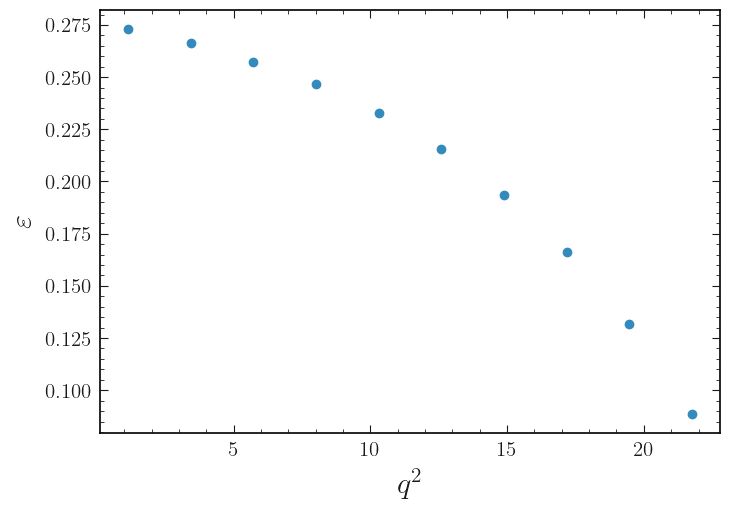

In [9]:
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

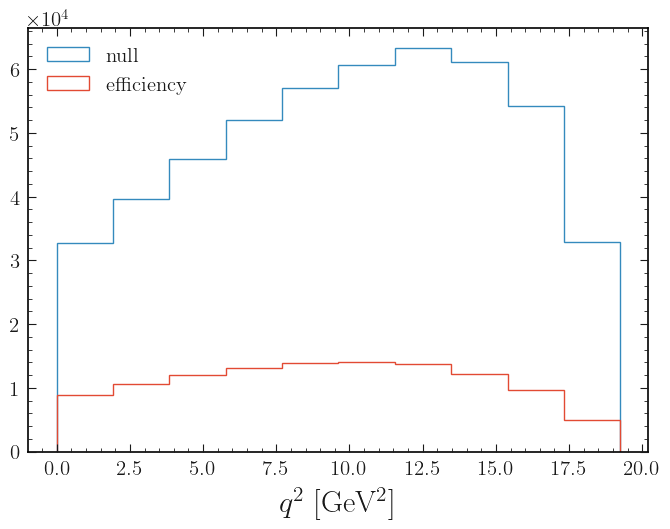

In [43]:
plt.hist(null_samples, binning, histtype='step', label='null')
null_yields, _, _ = plt.hist(null_samples, binning, weights = efficiency(null_samples), histtype='step', label='efficiency')

plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [11]:
p['sbnunu::Re{cVL}'].set(cvl)
p['sbnunu::Re{cVR}'].set(cvr)
p['sbnunu::Re{cSL}'].set(csl)
p['sbnunu::Re{cSR}'].set(csr)
p['sbnunu::Re{cTL}'].set(ctl)


BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=9999))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

### Apply efficiency


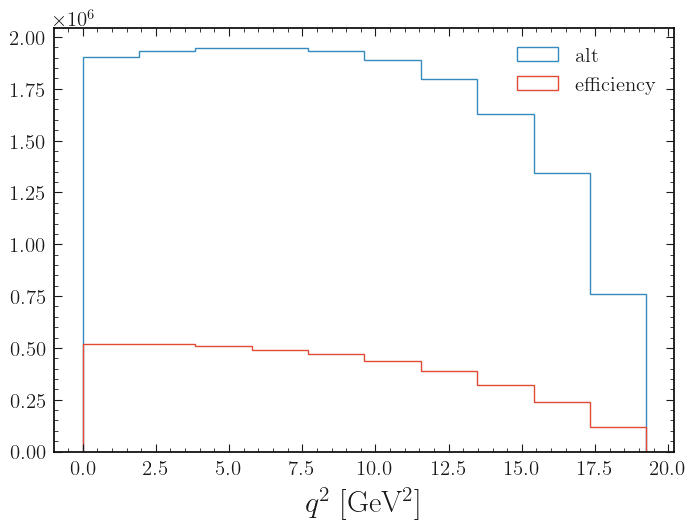

In [52]:
plt.hist(alt_samples, binning, histtype='step', label='alt')
alt_yields, _, _ = plt.hist(alt_samples, binning, weights = efficiency(alt_samples), histtype='step', label='efficiency')

plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.legend()

## Setup

In [45]:
null = null_pred()
alt = alt_pred()

In [46]:
ana  = analysis()

v0   = ana.parameters['B->K^*::alpha^V_0@BSZ2015'  ].evaluate()
v1   = ana.parameters['B->K^*::alpha^V_1@BSZ2015'  ].evaluate()
v2   = ana.parameters['B->K^*::alpha^V_2@BSZ2015'  ].evaluate()
a00  = ana.parameters['B->K^*::alpha^A0_0@BSZ2015' ].evaluate() 
a01  = ana.parameters['B->K^*::alpha^A0_1@BSZ2015' ].evaluate() 
a02  = ana.parameters['B->K^*::alpha^A0_2@BSZ2015' ].evaluate()
a10  = ana.parameters['B->K^*::alpha^A1_0@BSZ2015' ].evaluate()
a11  = ana.parameters['B->K^*::alpha^A1_1@BSZ2015' ].evaluate()
a12  = ana.parameters['B->K^*::alpha^A1_2@BSZ2015' ].evaluate()
a121 = ana.parameters['B->K^*::alpha^A12_1@BSZ2015'].evaluate()
a122 = ana.parameters['B->K^*::alpha^A12_2@BSZ2015'].evaluate()
t10  = ana.parameters['B->K^*::alpha^T1_0@BSZ2015' ].evaluate()
t11  = ana.parameters['B->K^*::alpha^T1_1@BSZ2015' ].evaluate()
t12  = ana.parameters['B->K^*::alpha^T1_2@BSZ2015' ].evaluate()
t21  = ana.parameters['B->K^*::alpha^T2_1@BSZ2015' ].evaluate()
t22  = ana.parameters['B->K^*::alpha^T2_2@BSZ2015' ].evaluate()
t230 = ana.parameters['B->K^*::alpha^T23_0@BSZ2015'].evaluate()
t231 = ana.parameters['B->K^*::alpha^T23_1@BSZ2015'].evaluate()
t232 = ana.parameters['B->K^*::alpha^T23_2@BSZ2015'].evaluate()

In [47]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana, chains = 5, samples = 10000)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.000496,0.000170,-0.012269,0.000162,0.000365,-0.000900,0.002674,0.004422,0.000112,-0.000338,0.001091,0.000091,-0.000031,-0.001049,0.000357,0.000203,0.000166,0.000580,-0.000644
1,0.000170,0.029694,0.089715,-0.000040,0.002578,-0.002977,0.009469,0.037270,-0.000262,0.002831,-0.029321,-0.000163,0.000135,0.004835,-0.001036,-0.002803,-0.000400,-0.000057,0.009558
2,-0.012269,0.089715,2.338863,-0.000908,-0.011460,0.105152,-0.074998,0.086737,0.000552,-0.016807,0.248802,0.000562,-0.001207,-0.028987,0.002641,-0.015255,-0.002524,-0.002429,0.071072
3,0.000162,-0.000040,-0.000908,0.000229,0.000632,-0.002689,0.000713,0.001677,0.000248,-0.000096,-0.005174,0.000195,0.000042,-0.002805,0.000877,0.000335,0.000219,0.000837,0.000778
4,0.000365,0.002578,-0.011460,0.000632,0.011066,0.035157,0.013463,0.076331,0.000916,0.001880,-0.044458,0.000735,0.000283,-0.010544,0.003594,0.003224,0.000767,0.003008,0.004825
5,-0.000900,-0.002977,0.105152,-0.002689,0.035157,0.405435,0.042048,0.348329,-0.001107,-0.005189,0.102336,-0.000989,-0.001455,0.012863,-0.002987,0.014271,-0.001015,-0.008910,-0.025907
6,0.002674,0.009469,-0.074998,0.000713,0.013463,0.042048,0.077593,0.436575,0.000331,0.002494,-0.032327,0.000348,-0.000272,-0.001228,0.001699,0.002011,0.000554,0.002602,0.003339
7,0.004422,0.037270,0.086737,0.001677,0.076331,0.348329,0.436575,2.999522,0.000982,0.012465,-0.102225,0.001105,-0.002301,-0.000414,0.007297,0.013450,0.000587,0.005758,0.048128
8,0.000112,-0.000262,0.000552,0.000248,0.000916,-0.001107,0.000331,0.000982,0.000530,-0.000858,-0.022202,0.000268,0.000042,-0.003637,0.001208,0.000505,0.000305,0.001034,-0.000182
9,-0.000338,0.002831,-0.016807,-0.000096,0.001880,-0.005189,0.002494,0.012465,-0.000858,0.021821,0.069352,-0.000045,0.000349,-0.001173,0.000129,0.000209,-0.000326,0.000461,0.015776


In [48]:
cvlSM = eos.Parameters()['sbnunu::Re{cVL}'].evaluate()

new_params = {
                'cvl'   :{'inits': (cvlSM,), 'bounds': ((3., 14.),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csr'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'FFKs'    :{'inits': (v0, v1, v2, a00, a01, a02, a10, a11, a12, a121, a122, t10, t11, t12, t21, t22, t230, t231, t232), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

In [49]:
spec = {
  "channels": [
    {
      "name": "B->Ksnunu",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
basemodel = pyhf.Model(spec)

custom_mod = {
                "name": "ksnunu_theory",
                "type": "ksnunu",
                "data":{"expr": "ksnunu_weight_fn"}
              }

## Check convergence for different binnings

In [50]:
max_bins = 0

#loop random  models
for m in range(100):
    np.random.seed(123+m)
    cvl, cvr, csl, csr, ctl = np.random.normal(0.0, 10.0, 5)
    cvl += cvlSM
    
    old = None
    #loop over number of bins
    for n in range(1, 30):
        q2binning = np.linspace(0.0, 19.25, n+1)

        mapping_dist = modifier.map(null_samples.flatten(), [null_samples.flatten()], binning, [q2binning])
        mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

        cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='ksnunu')

        model = modifier.add_to_model(deepcopy(basemodel), ['B->Ksnunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
        
        init = model.config.suggested_init()
        init[model.config.par_map['cvl']['slice']] = [cvl]
        init[model.config.par_map['cvr']['slice']] = [cvr]
        init[model.config.par_map['csl']['slice']] = [csl]
        init[model.config.par_map['csr']['slice']] = [csr]
        init[model.config.par_map['ctl']['slice']] = [ctl]
        
        try:
            new = model.expected_actualdata(init)
            diff = abs(new-old)/old
            # check if the difference is larger than 1%
            if not any(diff > 1e-2):
                max_bins = max(max_bins, n)
                break
        except:
            pass
        
        old = model.expected_actualdata(init)
        
print('max bins', max_bins)

max bins 22


## Compare to data

1 [0.41299336 0.29936493 0.1922394  0.08602072 0.00867109 0.09873027
 0.20640395 0.28354305 0.37825078 0.45040299]
2 [0.26811418 0.12644108 0.00712483 0.1395595  0.25762232 0.12660223
 0.04101244 0.02030777 0.09560776 0.15309453]
3 [0.17988621 0.02113456 0.12853291 0.00053607 0.0409544  0.04467415
 0.06212519 0.04753698 0.02276097 0.07646796]
4 [0.12483547 0.0445725  0.02851536 0.01929943 0.08230497 0.06135567
 0.03062866 0.00896523 0.0119481  0.03995794]
5 [0.08728437 0.08939248 0.05739279 0.06655794 0.04290088 0.04255389
 0.02829775 0.0338354  0.03257034 0.01826568]
6 [0.06004264 0.03393116 0.00279423 0.00185892 0.03591507 0.03039133
 0.02114088 0.00449533 0.00512823 0.00378627]
7 [0.03937934 0.00846961 0.02567645 0.00111179 0.00290258 0.00816524
 0.01433819 0.01471955 0.0017496  0.00660996]
8 [0.02316895 0.00102346 0.0069512  0.01610208 0.01445658 0.01369411
 0.00540043 0.00331024 0.0010933  0.01445677]
9 [0.0101123  0.00221099 0.00121669 0.00726211 0.00395207 0.00029895
 0.01107097

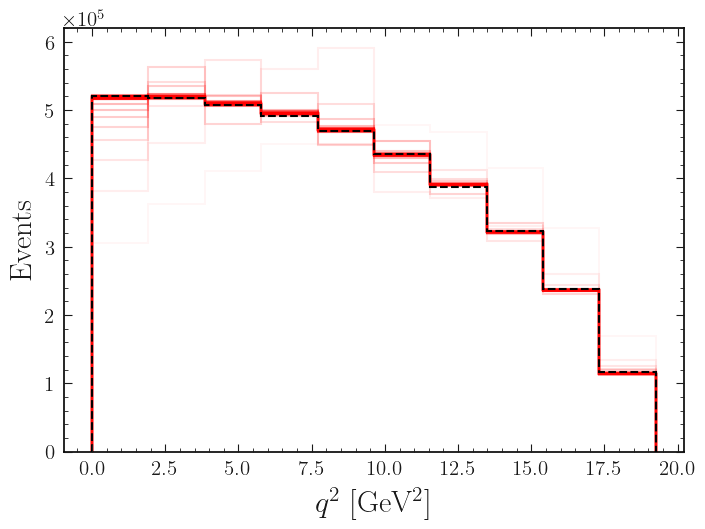

In [58]:
cvl = 8.0
cvr = 4.0
csl = 3.0
csr = 1.0
ctl = 5.0

#loop over number of bins
maxbins = 30
for n in range(1, maxbins):
    q2binning = np.linspace(0.0, 19.25, n+1)

    mapping_dist = modifier.map(null_samples.flatten(), [null_samples.flatten()], binning, [q2binning])
    mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

    cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='ksnunu')

    model = modifier.add_to_model(deepcopy(basemodel), ['B->Ksnunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
    
    init = model.config.suggested_init()
    init[model.config.par_map['cvl']['slice']] = [cvl]
    init[model.config.par_map['cvr']['slice']] = [cvr]
    init[model.config.par_map['csl']['slice']] = [csl]
    init[model.config.par_map['csr']['slice']] = [csr]
    init[model.config.par_map['ctl']['slice']] = [ctl]
    
    new = model.expected_actualdata(init)

    plt.stairs(new, binning, color='r', alpha=n/maxbins, linewidth=1.5)
    
    print(n, abs(new-alt_yields)/alt_yields)

plt.stairs(alt_yields, binning, color='k', linestyle='dashed', linewidth=1.5)

plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.ylabel(r'Events')

plt.show()